In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchtuples as tt 

from load import read_csv

from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn_pandas import DataFrameMapper


In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
datapath = './Data/data.csv'
data = read_csv(datapath)
print(len(data))

52777


In [4]:
df_test = data.sample(frac=0.2)
df_train = data.drop(df_test.index)
df_val = df_train.sample(frac=0.1)
df_train = df_train.drop(df_val.index)

In [5]:
pd.set_option('display.max_columns', None)
df_train.head()

,GRADE,AGE,SEX,QUINTILE_2015,TUMOUR_COUNT,SACT,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,SITE_C13,SITE_C17,SITE_C20,SITE_C21,SITE_C22,SITE_C23,SITE_C24,SITE_C25,SITE_C43,SITE_C48,SITE_C50,SITE_C53,SITE_C64,SITE_C65,SITE_C70,SITE_C71,SITE_C72,SITE_C73,SITE_C78,SITE_C79,SITE_C80,SITE_C82,SITE_C91,SITE_D01,SITE_D09,SITE_D32,SITE_D33,SITE_D35,SITE_D37,SITE_D41,SITE_D43,SITE_D47,SITE_C44,SITE_C51,SITE_C54,SITE_C67,SITE_C77,SITE_C84,SITE_C92,SITE_D03,BENIGN_BEHAVIOUR,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701,LAT_9,LAT_B,LAT_L,LAT_M,LAT_R,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,EVENT
0,4,69.0,1,4,2,0,False,False,0.0,0,0,0.000,0.00,0,751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,4,88.0,1,1,2,1,False,False,1.0,0,0,1.755,71.75,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,4,88.0,1,1,2,1,False,False,3.0,0,0,1.755,71.75,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,4,88.0,1,1,2,1,False,False,2.0,0,0,1.755,71.75,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,4,88.0,1,1,2,1,False,False,4.0,0,0,1.755,71.75,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1


In [6]:
# cols = list(df_train.columns.values)
# print(cols)
df_train = df_train[['GRADE', 'AGE', 'SEX', 'QUINTILE_2015', 'TUMOUR_COUNT', 'SACT', 'CLINICAL_TRIAL','CHEMO_RADIATION','REGIMEN_COUNT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT', 'BENIGN_BEHAVIOUR', 'SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32', 'SITE_D33', 'SITE_D35', 'CREG_L0201', 'CREG_L0301', 'CREG_L0401', 'CREG_L0801', 'CREG_L0901', 'CREG_L1001', 'CREG_L1201', 'CREG_L1701', 'LAT_9', 'LAT_B', 'LAT_L', 'LAT_M', 'LAT_R', 'ETH_A', 'ETH_B', 'ETH_C', 'ETH_M', 'ETH_O', 'ETH_U', 'ETH_W', 'DAYS_SINCE_DIAGNOSIS','EVENT']]
df_train.head()

,GRADE,AGE,SEX,QUINTILE_2015,TUMOUR_COUNT,SACT,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,BENIGN_BEHAVIOUR,SITE_C70,SITE_C71,SITE_C72,SITE_D32,SITE_D33,SITE_D35,CREG_L0201,CREG_L0301,CREG_L0401,CREG_L0801,CREG_L0901,CREG_L1001,CREG_L1201,CREG_L1701,LAT_9,LAT_B,LAT_L,LAT_M,LAT_R,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,DAYS_SINCE_DIAGNOSIS,EVENT
0,4,69.0,1,4,2,0,False,False,0.0,0,0,0.000,0.00,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,751,0
1,4,88.0,1,1,2,1,False,False,1.0,0,0,1.755,71.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,1
2,4,88.0,1,1,2,1,False,False,3.0,0,0,1.755,71.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,1
3,4,88.0,1,1,2,1,False,False,2.0,0,0,1.755,71.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,1
4,4,88.0,1,1,2,1,False,False,4.0,0,0,1.755,71.75,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,1


In [7]:
cols_standardise = ['GRADE', 'AGE', 'QUINTILE_2015', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT']
cols_minmax = ['SEX', 'TUMOUR_COUNT', 'REGIMEN_COUNT']
cols_leave = ['SACT', 'CLINICAL_TRIAL',	'CHEMO_RADIATION','CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR','BENIGN_BEHAVIOUR','SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32','SITE_D33','SITE_D35','CREG_L0201','CREG_L0301','CREG_L0401','CREG_L0801','CREG_L0901','CREG_L1001','CREG_L1201','CREG_L1701','LAT_9','LAT_B','LAT_L','LAT_M','LAT_R','ETH_A','ETH_B','ETH_C','ETH_M','ETH_O','ETH_U','ETH_W','DAYS_SINCE_DIAGNOSIS','EVENT']

standardise = [([col], StandardScaler()) for col in cols_standardise]
minmax = [([col], MinMaxScaler()) for col in cols_minmax]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardise + minmax + leave)

In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [9]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df.DAYS_SINCE_DIAGNOSIS.values, df.EVENT.values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [10]:
labtrans.cuts

array([   0.        ,  247.88888889,  495.77777778,  743.66666667,
        991.55555556, 1239.44444444, 1487.33333333, 1735.22222222,
       1983.11111111, 2231.        ])

In [11]:
in_features = x_train.shape[1]
num_nodes = [32, 32, 32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [12]:
model = LogisticHazard(net, tt.optim.Adam(0.001), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [13]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [14]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.5284,	val_loss: 0.8132
1:	[0s / 1s],		train_loss: 0.5779,	val_loss: 0.3386
2:	[0s / 1s],		train_loss: 0.3302,	val_loss: 0.2470
3:	[0s / 2s],		train_loss: 0.2521,	val_loss: 0.1759
4:	[0s / 2s],		train_loss: 0.2120,	val_loss: 0.1742
5:	[0s / 3s],		train_loss: 0.1978,	val_loss: 0.1270
6:	[0s / 3s],		train_loss: 0.1824,	val_loss: 0.1579
7:	[0s / 4s],		train_loss: 0.1784,	val_loss: 0.1211
8:	[0s / 5s],		train_loss: 0.1773,	val_loss: 0.1167
9:	[0s / 5s],		train_loss: 0.1590,	val_loss: 0.1578
10:	[0s / 6s],		train_loss: 0.1617,	val_loss: 0.2702
11:	[0s / 6s],		train_loss: 0.1683,	val_loss: 0.1332
12:	[0s / 7s],		train_loss: 0.1551,	val_loss: 0.1691
13:	[0s / 7s],		train_loss: 0.1371,	val_loss: 0.0804
14:	[0s / 8s],		train_loss: 0.1432,	val_loss: 0.2016
15:	[0s / 8s],		train_loss: 0.1299,	val_loss: 0.2358
16:	[0s / 9s],		train_loss: 0.1378,	val_loss: 0.1022
17:	[0s / 9s],		train_loss: 0.1315,	val_loss: 0.0808
18:	[0s / 10s],		train_loss: 0.1355,	val_loss: 0.1353
19

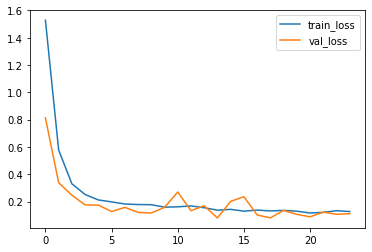

In [15]:
_ = log.plot()

In [16]:
surv = model.predict_surv_df(x_test)

In [17]:
surv = model.interpolate(10).predict_surv_df(x_test)

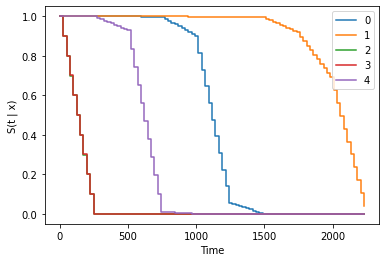

In [18]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [19]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [20]:
ev.concordance_td('antolini')

0.9495222646275534

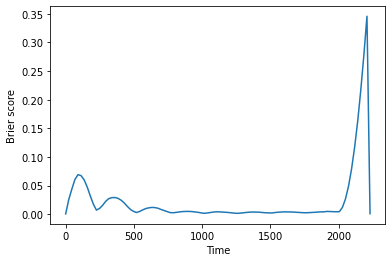

In [21]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')